## Problem 2. scRNA-seq data and Autoencoders (20 points)

**Background:** Single-cell RNA-seq (scRNA-seq) data are often noisy and sparse, e.g. only a fraction of transcribed RNAs are captured in the sequencing due to the difficulty of amplifying a small signal from a single cell. While there are many genes expressed in a cell at any given time, two entirely different RNA-seq profiles could come from cells with similar expression levels. In this assignment, you will explore how to utilize autoencoders to identify clusters of scRNA-seq profiles. These clusters could represent varying expression profiles from cells of the same cell type, such as the profiles that you might see in different phases of the cell cycle. 

**Dataset:** Facing these challenges, simulation is important for conducting repeatable experiments with ground truth to test the performance of methods. Splatter is a software package for generating such simulated scRNA-seq count data, which can be used for evaluation. The data are provided in the form of normalized log counts across 1000 genes in 5000 cells. The gene expression matrix is provided as ./counts.npy, and the label file is ./labels.txt.


Given the skeleton code below, you should fill out the 'TBD' parts: 

**1. [12 points]** Train an Autoencoder to learn the distribution of scRNA-seq counts (refer to **'Implementation Notes'** to get more details of network).

(a) [8 points] Finish the **Autoencoder** code (from 'define model' to 'obtain latent vectors'). Use latent embedding sizes (i.e. the size of the output of the encoder, and the input to the decoder) of 5, 10, 50, and 100.

(b) [4 points] Report and compare their reconstruction Mean Squared Errors (MSEs). How does the size of the latent space affect the reconstruction MSE? (Please draw the loss function of MSE over epochs in the training and describe your observation).


**2. [8 points]** Analyze the learned encodings. We have provided code to produce a PCA plot and a t-SNE plot of the raw RNA-seq data.

(a) [3 points] Adapt the provided code to make PCA and t-SNE plots of the data reconstructed by the 4 autoencoders.

(b) [3 points] Take the trained Encoders and make PCA and t-SNE plots of the latent vectors. Remember to draw plots for all the 4 autoencoders.

(c) [1 points] Report the plots of the original data with those of the reconstructed data. How are the PCA and t-SNE plots of the reconstructed data qualitatively different from those of the original data? 

(d) [1 points] Report the plots of the original data with the plots of the latent vectors. How do the various embedding sizes change the quality of clustering?

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader

# import tensorflow as tf
# from tensorflow import keras
%matplotlib inline


# Terminology Note: Latent vector = Latent Representation = Encoding = Output of Encoder

### Parameters, loading data and helper function

In [2]:
num_epochs = 200
batch_size = 128
l_r = 1e-4
latent_size = 50

# Helper method as an example to return the output mask
def return_out_mask(batch_data: np.array) -> np.array:
    '''
    Input: NxM np.array of counts data
    Output: NxM np.array filled with 1 corresponding to non-zero inputs
            and 0 corresponding to dropped inputs
    '''
    zero_indices = np.nonzero(batch_data == 0)
    mask = np.ones_like(batch_data)
    zeros = np.zeros_like(batch_data)
    mask[zero_indices] = zeros[zero_indices] # Fills in 0's into appropriate indices
    return mask


# Load Data
dataset = np.load('counts.npy')
labels = np.loadtxt("labels.txt")
print('labels shape: ',labels.shape)
print('dataset shape: ',dataset.shape)
pd.DataFrame(dataset)[:5] # 5000 x 1000 (cell x gene)

labels shape:  (5000,)
dataset shape:  (5000, 1000)


0         1         2         3         4    5         6        7    \
0  4.818027  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.00000   
1  4.949290  5.332359  4.106732  4.176539  0.000000  0.0  0.000000  0.00000   
2  4.590253  4.791590  0.000000  4.137063  4.791590  0.0  0.000000  0.00000   
3  5.599136  0.000000  0.000000  3.516551  0.000000  0.0  0.000000  3.25479   
4  3.184195  5.290426  0.000000  3.356862  3.650348  0.0  3.356862  0.00000   

        8    9    ...       990       991       992       993       994  \
0  3.595109  0.0  ...  0.000000  7.875205  0.000000  5.403121  6.033264   
1  5.100612  0.0  ...  3.695760  5.863619  3.956085  5.170709  5.609743   
2  3.563473  0.0  ...  0.000000  8.038405  3.563473  5.001115  5.445224   
3  4.735300  0.0  ...  4.513363  8.495263  4.388123  5.284629  5.481427   
4  0.000000  0.0  ...  0.000000  7.935692  0.000000  0.000000  4.591724   

        995  996       997        998       999  
0  4.332443  0.0  5.625551   9.738974  4.711081  
1  5.820660  0.0  5.477707  10.617377  3.377886  
2  5.294245  0.0  6.289117   9.903455  4.013606  
3  4.881876  0.0  6.055585  10.006094  3.837205  
4  4.591724  0.0  5.877299   9.279790  4.284677  

[5 rows x 1000 columns]

In [19]:
def return_out_mask(batch_data):
    '''
    Input: NxM np.array of counts data
    Output: NxM np.array filled with 1 corresponding to non-zero inputs
            and 0 corresponding to dropped inputs
    '''
    batch_data_numpy = batch_data.numpy()
    zero_indices = np.nonzero(batch_data_numpy == 0)
    mask = np.ones_like(batch_data_numpy)
    zeros = np.zeros_like(batch_data_numpy)
    mask[zero_indices] = zeros[zero_indices] # Fills in 0's into appropriate indices
    mask_torch  = torch.from_numpy(mask)
    return mask_torch

In [20]:
a = torch.rand(3,5)
a[0,1] = 0
a[1,3] = 0
print(a)
return_out_mask(a)

tensor([[0.1664, 0.0000, 0.0685, 0.6374, 0.9249],
        [0.0922, 0.2057, 0.1694, 0.0000, 0.5428],
        [0.5462, 0.7011, 0.0717, 0.8198, 0.5860]])


tensor([[1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1.]])

**Implementation Notes:**  

(1) Each Autoencoder should have 5 layers, with sizes 1000, 100, 10, 100 and 1000 from input to output, respectively.

(2) Test your AEs with ~200 epochs.

(3) Use a couple of dropout layers to help prevent overfitting on this small dataset. No validation set is necessary for this task.    

(4) You need to mask the outputs of the autoencoder that correspond to 0's (dropped counts) in the input. The autoencoder learns best when it is not forced to also learn to reconstruct the zeros in the input. This technique is known as 
gradient masking, and is commonly used in situations like this to prevent a training signal to reconstruct unimportant data.
To acheive this, the reconstruction output of the autoencoder must be multiplied by a mask that zeros the corresponding
dropped counts of the inputs, which ensures the gradient from that particular output is zero. Use MSE loss, and only average over
the number of non-zero elements in the batch. You have been provided with a helper method in order to do the masking, which you may adapt or use as is.

Hint: Feel free to experiment with the size of the network and hyperparameters. 

### Autoencoder

In [4]:
# Pytorch Dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(dataloader)

In [4]:
# Define Model, Optimizer, and Loss
#####################################################
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder  =  nn.Sequential(
            nn.Linear(1000,100),
            nn.Tanh(),
            nn.Linear(100, 10),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()

        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
#####################################################

In [1]:
# Training Loop
#####################################################
TBD
#####################################################

# Save model weights (Optional)
#####################################################
TBD
#####################################################

# Obtain Encoded Representations & Reconstructions
#   Run just the trained encoder across dataset to obtain latent vectors
#####################################################
TBD
#####################################################

'\nTBD\n'

### Visualization and analysis

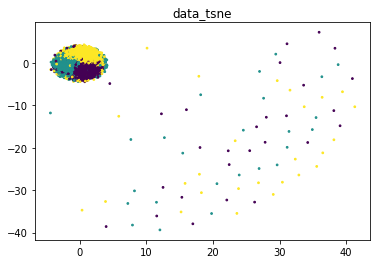

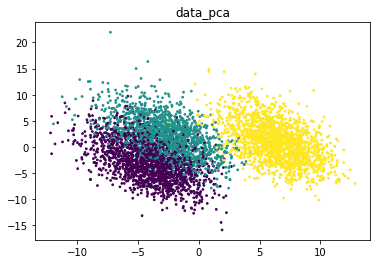

In [9]:
# T-SNE & PCA Plot of Counts Data
tsne_data = TSNE(n_components=2).fit_transform(dataset)
plt.scatter(tsne_data[:,0],tsne_data[:,1],c=labels,s=3)
plt.title('data_tsne')
plt.show()

pca = PCA(n_components=2)
pca_data = pca.fit_transform(dataset)
plt.scatter(pca_data[:,0],pca_data[:,1],c=labels,s=3)
plt.title('data_pca')
plt.show()

In [ ]:
'''
Fill the ? in the following parts, i.e., specify the 'encoded_data'and 'econstructions'
'''

In [2]:
# T-SNE & PCA Plot of Encodings
#####################################################
encoded_data = ? # np.array
#####################################################

tsne_latent = TSNE(n_components=2).fit_transform(encoded_data)
plt.scatter(tsne_latent[:,0],tsne_latent[:,1],c=labels,s=3)
plt.title('encoded_tsne')
plt.show()

pca = PCA(n_components=2)
pca_data = pca.fit_transform(encoded_data)
plt.scatter(pca_data[:,0],pca_data[:,1],c=labels,s=3)
plt.title('encoded_pca')
plt.show()

SyntaxError: invalid syntax (<ipython-input-2-de8e666a6dd7>, line 2)

In [1]:
# T-SNE & PCA Plot of Reconstructions
#####################################################
reconstructions= ?
#####################################################
tsne_latent = TSNE(n_components=2).fit_transform(reconstructions)
plt.scatter(tsne_latent[:,0],tsne_latent[:,1],c=labels,s=3)
plt.title('reconstructed_tsne')
plt.show()

pca = PCA(n_components=2)
pca_data = pca.fit_transform(reconstructions)
plt.scatter(pca_data[:,0],pca_data[:,1],c=labels,s=3)
plt.title('reconstructed_pca')
plt.show()

SyntaxError: invalid syntax (<ipython-input-1-6de71e610801>, line 2)